In [1]:
from matplotlib import pyplot as plt


In [2]:
years = [1950, 1960, 1970, 1980, 1990, 2000, 2010]
gdp = [300.2, 543.3, 1075.9, 2862.5, 5979.6, 10289.7, 14958.3]

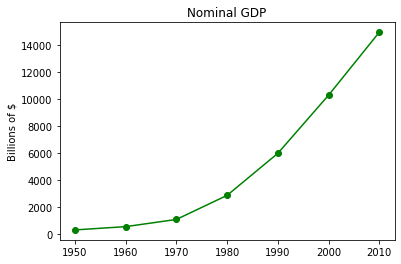

In [6]:
plt.plot(years, gdp , color='green' , marker='o' , linestyle='solid')
plt.title('Nominal GDP')
plt.ylabel('Billions of $')
plt.show()

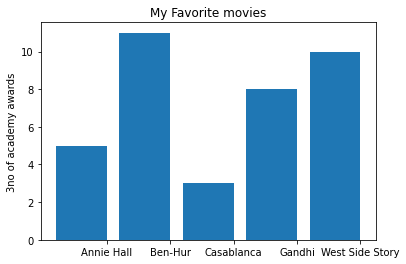

In [7]:
#bar chart
movies = ["Annie Hall", "Ben-Hur", "Casablanca", "Gandhi", "West Side Story"]
num_oscars = [5 , 11 , 3 , 8 , 10]
xs = [i + 0.1 for i, _ in enumerate(movies)]
plt.bar(xs , num_oscars)
plt.ylabel("3no of academy awards")
plt.title("My Favorite movies")
plt.xticks([i + 0.5 for i, _ in enumerate(movies)], movies)
plt.show()

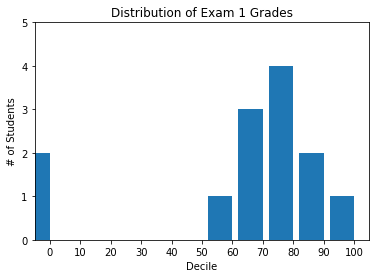

In [9]:
from collections import Counter
grades = [83,95,91,87,70,0,85,82,100,67,73,77,0]
decile = lambda grade: grade // 10*10
histogram = Counter(decile(grade) for grade in grades)
plt.bar([x - 4 for x in histogram.keys()], histogram.values() , 8)
plt.axis([-5, 105 , 0 , 5])
plt.xticks([10*i for i in range(11)])
plt.xlabel("Decile")
plt.ylabel("# of Students")
plt.title("Distribution of Exam 1 Grades")
plt.show()

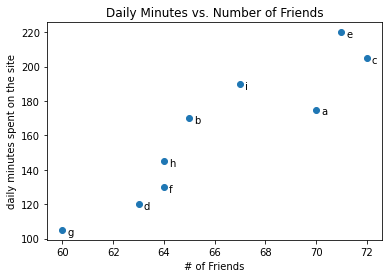

In [10]:
friends = [ 70, 65, 72, 63, 71, 64, 60, 64, 67]
minutes = [175, 170, 205, 120, 220, 130, 105, 145, 190]
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
plt.scatter(friends , minutes)
for label , friend_count , minute_count in zip(labels , friends , minutes):
  plt.annotate(label , xy = (friend_count ,minute_count) , xytext=(5 , -5), textcoords='offset points')
plt.title("Daily Minutes vs. Number of Friends")
plt.xlabel("# of Friends")
plt.ylabel("daily minutes spent on the site")
plt.show()

# Linear Agebra

In [11]:
#matrices
A =[[1,2,3] , 
    [4,5,6]]

def shape(A):
    num_rows = len(A)
    num_cols = len(A[0]) if A else 0
    return num_rows , num_cols

#return values in a row
def get_row(matrix , row):
    return matrix[row]

#return values in a column
def get_column(matrix , column):
    return [matrix_row[column]for matrix_row in matrix]

#Make matrix given its shape and function
def make_matrix(num_rows , num_cols , entry_fn):
    return [[entry_fn(i, j)
            for j in range(num_cols)]
           for i in range(num_rows)]

#example of a matrix making ufunction
def is_diagonal(i , j):
    return 1 if i == j else 0

identity_matrix = make_matrix(5 ,6 , is_diagonal)
identity_matrix

[[1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 0]]

Uses of matrices 
1. To represent a dataset consisting of ultiple vectors
2. to represent a linear function that maps k-dimensional vectors to n-dimesional vectors
3. To represent binary relationships


In [24]:
#data sciencestar data 
users = [
    { "id": 0, "name": "Hero" },
    { "id": 1, "name": "Dunn" },
    { "id": 2, "name": "Sue" },
    { "id": 3, "name": "Chi" },
    { "id": 4, "name": "Thor" },
    { "id": 5, "name": "Clive" },
    { "id": 6, "name": "Hicks" },
    { "id": 7, "name": "Devin" },
    { "id": 8, "name": "Kate" },
    { "id": 9, "name": "Klein" }
]
friendships = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4),
(4, 5), (5, 6), (5, 7), (6, 8), (7, 8), (8, 9)]

#add a list of friends to each user
for user in users:
    user["friends"]= []
    
#populate the users friend
for i , j in friendships:
    users[i]["friends"].append(users[j])
    users[j]["friends"].append(users[i])
    
#get total connections per user
def number_of_friends(user):
    return len(user["friends"])
total_connections = sum(number_of_friends(user) for user in users)

#getting friends of friends\
from collections import  Counter
def not_the_same(user, other_user):
    return user["id"] != other_user["id"]
def not_friends(user , other_user):
    return all(not_the_same(friend , other_user) for friend in user["friends"])
def friends_of_friend_ids(user):
    return Counter (foaf["id"]
                   for friend in user["friends"]
                   for foaf  in friend["friends"]
                   if not_the_same(user , foaf)
                   and not_friends(user , foaf))
interests = [
(0, "Hadoop"), (0, "Big Data"), (0, "HBase"), (0, "Java"),
(0, "Spark"), (0, "Storm"), (0, "Cassandra"),
(1, "NoSQL"), (1, "MongoDB"), (1, "Cassandra"), (1, "HBase"),
(1, "Postgres"), (2, "Python"), (2, "scikit-learn"), (2, "scipy"),
(2, "numpy"), (2, "statsmodels"), (2, "pandas"), (3, "R"), (3, "Python"),
(3, "statistics"), (3, "regression"), (3, "probability"),
(4, "machine learning"), (4, "regression"), (4, "decision trees"),
(4, "libsvm"), (5, "Python"), (5, "R"), (5, "Java"), (5, "C++"),
(5, "Haskell"), (5, "programming languages"), (6, "statistics"),
(6, "probability"), (6, "mathematics"), (6, "theory"),
(7, "machine learning"), (7, "scikit-learn"), (7, "Mahout"),
(7, "neural networks"), (8, "neural networks"), (8, "deep learning"),
(8, "Big Data"), (8, "artificial intelligence"), (9, "Hadoop"),
(9, "Java"), (9, "MapReduce"), (9, "Big Data")
]
#find users with common interests
def data_scientists_who_like(target_interest):
    return [user_id 
            for user_id , user_interest in interests
           if user_interest == target_interest]
from collections import defaultdict
#make the interest the keys
user_ids_by_interest = defaultdict(list)
for user_id , interest in interests:
    user_ids_by_interest[interest].append(user_id)
#make the user_ids the keys
interests_by_user_id = defaultdict(list)
for user_id, interest in interests:
interests_by_user_id[user_id].append(interest)

def most_common_interests_with(user):
    return Counter(interested_user_id
                  for interest in interests_by_user_id[user["id"]]
                  for interested_user_id in user_ids _by_interest[interest]
                  if interested_user_id != user["id"])

# Linear Algebra

In [ ]:
##DISPERSION
def data_range(x):
    return max(x) - min(x)

def dot(v, w):
    return sum(v_i * w_i for v_i , w_i in zip(v,w))

def sum_of_squares(v):
    return dot(v ,v)

def de_mean(x):
    x_bar = mean(x)
    return [x_i -x_bar for x_i in x]

def variance(x):
    n = len(x)
    deviations = de_mean(x)
    return sum_of_squares(deviations)/(n-1)

def standard_deviation(x):
    return math.sqrt(variance(x))

def covariance(x,y):
    n = len(x)
    return dot(de_mean(x),de_mean(y))/(n-1)

def correlation(x,y):
    stdev_x = standard_deviation(x)
    stdev_y = standard_deviation(y)
    if stdev_x > 0 and stdev_y >0:
        return covariance(x,y) / stdev_x /stdev_y
    else:
        return 0


One common tricky probability example involves a family with two (unknown) children . If we assume that:
1. Each child is equally likely to be a boy or a girl
2. The gender of the second child is independent of that of the first


In [6]:
import random
def random_kid():
    return random.choice(["boy" , "girl"])
both_girls = 0
older_girl = 0
either_girl = 0
random.seed(0)
for _ in range(1000):
    younger = random_kid()
    older = random_kid()
    if older == "girl":
        older_girl += 1
    if older == "girl" and younger == "girl":
        both_girls += 1
    if older == "girl" or younger == "girl":
        either_girl += 1
print("P(both | older):", both_girls /older_girl)
print("P (both |either):" ,both_girls / either_girl)

P(both | older): 0.4949290060851927
P (both |either): 0.32232496697490093


# Density Function for uiniform distribution

In [ ]:
def uniform_pdf(x):
    return 1 if x >= 0 and x < 1 else 0


The cumulative distribution function : Represents the probability that a random variable is less than or equal to a certain value

In [7]:
def uniform_cdf(x):
    if x < 0 : return 0
    elif x < 1: return x
    else: return 1

In [14]:
def normal_cdf( x , mu=0 , sigma = 1):
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

In [ ]:
def inverse_normal_cdf( p , mu=0 , sigma=1 , tolerance=0.00001):
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_norma_cdf(p , tolerance = tolerance)
    low_z , low_p = -10.0 , 0
    hi_z , hi_p = 10.0 , 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2
        mid_p = normal_cdf(mid_z)
        if mid_p < p:
            low_z , low_p = mid_z , mid_p
        elif mid_p > p :
            hi_z , hi_p = mid_z , mid_p
        else:
            break
    return mid_z

# Normal Distribution
- king of distributions
- completely determnined by two parameters , mean (u) and the standard deviation.
Can be implemenented ad :

In [8]:
import math
def normal_pdf(x , mu = 0 , sigma = 1):
    sqrt_two_pi = math.sqrt(2 * math.pi)
    return (math.exp(-(x-mu) ** 2 / 2 / sigma **2 ) / (sqrt_two_pi * sigma))

Plot some normal distributions

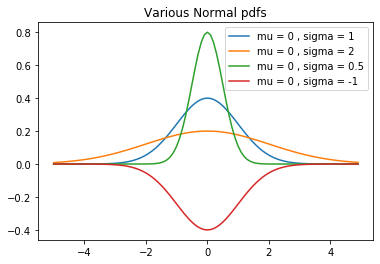

In [12]:
import matplotlib.pyplot as plt
xs = [x / 10.0 for x in range(-50 , 50)]
plt.plot(xs , [normal_pdf(x , sigma = 1) for x in xs] , '-' , label = 'mu = 0 , sigma = 1')
plt.plot(xs , [normal_pdf(x , sigma = 2) for x in xs] , '-' , label = 'mu = 0 , sigma = 2')
plt.plot(xs , [normal_pdf(x , sigma = 0.5 ) for x in xs] , '-' , label = 'mu = 0 , sigma = 0.5')
plt.plot(xs , [normal_pdf(x , sigma = -1) for x in xs] , '-' , label = 'mu = 0 , sigma = -1')
plt.legend()
plt.title("Various Normal pdfs")
plt.show()

# Central Limit Theory
A random variable defined as the average of a large number of independent and identically distributed random variables is itself approvimately randomly distributed

In [15]:
def bernoulli_trial(p):
    return 1 if random.random() < p else 0
def binomial(n , p):
    return sum(bernoulli_trial(p) for _ in range(n))

# Statistical Hypothesis Testing

In [13]:
def normal_approximation_to_binomial(n , p):
    mu = p *n
    sigma = meth.sqrt(p * (1 - p) * n)
    return mu , sigma

In [16]:
#when a random variable follows a normal distribution , we can use the normal continous density function
#normal_cdf to figure out the robability that its realized value lies within or outside a particular interval
normal_probability_below  = normal_cdf
def normal_probability_above(lo , mu=0 , sigma=1):
    return 1 - normal_cdf(lo , mu , sigma)
def normal_probability_between(lo , hi , mu=0 , sigma=1):
    return normal_cdf(hi , mu, sigma) - normal_cdf(lo , mu , sigma)
def normal_probability_outside(lo , hi , mu=0 , sigma=1):
    return 1 - normal_probability_between(lo , hi , mu , sigma)

Let's say that NA people see ad A and that nA of them click it
We can think of each

In [ ]:
def estimated_parameters(N , n):
    p = n / N
    sigma =math.sqrt(p * (1-p) / N)
    return p , sigma

def a_b_test_statistic(N_A, n_A , N_b , n_b):
    p_A , sigma_A = estimated_paramters(N_A , n_A)
    p_B , sigma_B = estimated_parameters(N_B , n_B)
    retur